## **SISTEMA RECOMENDADOR DE NOTICIAS PARA CLIENTES CORPORATIVOS DE UN BANCO**



**Profesor**: Juan Fernando Perez Bernal

**Integrantes**: Miller Puentes, Joan Esteban Chacón, Grace González, Catalina Cárdenas

En este documento se presenta el Modelamiento de los datos para el desarrollo de un sistema de recomendación de noticias para los clientes de un banco basado en el sector económico al que pertenece.

### ***Tabla de contenido***

**0.   Instalación y llamada de librerías**

  0.1 Instalación de pyLDAvis

  0.2 Instalación de librerías

**3. Clustering de noticias**

  3.1 Modelo de clustering: LDA - Stemming

  a. Coherencia

  b. Perplejidad

  c. Modelo Final
  
  3.2 Modelo de clustering: LDA - Lematización
  
  a. Coherencia

  b. Perplejidad

  c. Modelo Final


## ***0. Instalación y llamada de librerías***

### ***0.1 Instalación de pyLDAvis***

In [ ]:
import pandas as pd
import numpy as np
import pyLDAvis

print(pd.__version__)
print(np.__version__)
print(pyLDAvis.__version__)

2.0.0
1.24.3
3.4.0


### ***0.2 Instalación de librerías***

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Importación de librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import unidecode
import spacy
from spacy.lang.es.examples import sentences
from unidecode import unidecode
import zipfile
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
import pyLDAvis.gensim_models
from gensim.corpora import Dictionary
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
# from transformers import AutoModel, AutoTokenizer
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from wordcloud import WordCloud
from pprint import pprint
from gensim.models import LdaModel

# Visualizamos los resultados
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Cargar el modelo de spacy para el español
nlp = spacy.load("es_core_news_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## ***3. Selección de temas de noticias***

En este punto nos centramos en identificar un tema subyacente con palabras comunes a través del modelo estadístico llamado "Asignación Latente de Dirichlet (LDA)" con la librería gensym.

LDA es un algoritmo de aprendizaje no supervisado que se utiliza para el modelado de tópicos. Su objetivo es identificar los tópicos ocultos (temas) dentro de un conjunto de documentos y asignar palabras a esos tópicos. Funciona bajo la suposición de que cada documento es una mezcla de varios tópicos, y cada palabra en un documento se atribuye a uno de esos tópicos.

Por necesidad del negocio es indispensable la asignación mínima de estos temas a cada una de las noticias para posteriormente recomendarlas a sus clientes basado en sus respectivos sectores:

* Macroeconomia
* Sostenibilidad
* Innovacion
* Regulaciones
* Alianzas
* Reputacion
* Otra



### ***3.1 Modelo de clustering: LDA - Stemming***



In [ ]:
df_bd_stemming=pd.read_csv('../Data/DC_stemming.csv')

Con el texto limpio por stemming se procede a agruparlo por temas:

In [ ]:
tokens_stemming = [word_tokenize(texto) for texto in df_bd_stemming['new_title_content']]

# Creamos la representación de diccionario del documento
dictionary_stemming = Dictionary(tokens_stemming)

# Se remueven las palabras que aparecen en menos de 20 documentos y más del 50% de los documentos
dictionary_stemming.filter_extremes(no_below=20, no_above=0.5)

# Se vectoriza el documento para crear el corpus con la matriz de frecuencia
corpus_stemming = [dictionary_stemming.doc2bow(doc) for doc in tokens_stemming]

print('Numero de palabras únicas: %d' % len(dictionary_stemming))

Numero de palabras únicas: 12806


Antes de definir el modelo se realizar la validación de coherencia y perplejidad para definir el mejor número de temas.

#### ***a. Coherencia***

In [ ]:
# Función para estimar la coherencia
def calcular_coherencia(dictionary, corpus, texts, start=1, limit=5, step=1):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        random_state=123,
                        passes=20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
modelos, valores_c = calcular_coherencia(dictionary=dictionary_stemming, corpus=corpus_stemming, texts=tokens_stemming, start=1, limit=20, step=3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


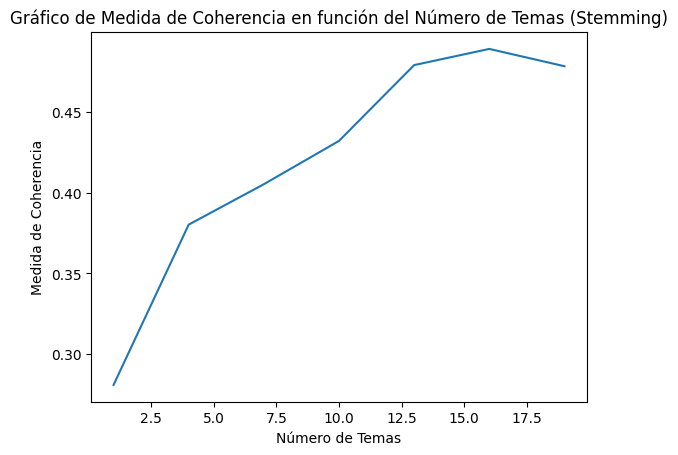

In [ ]:
limit=20; start=1; step=3;
x = range(start, limit, step)
plt.plot(x, valores_c)
plt.xlabel("Número de Temas")
plt.ylabel("Medida de Coherencia")
plt.title("Gráfico de Medida de Coherencia en función del Número de Temas (Stemming)")
plt.show()

La mayor coherencia se observa en los primeros 16 temas.

#### ***b. Perplejidad***

In [ ]:
# Función para estimar la perplejidad
def perplejidad_ntemas(dictionary, corpus, texts, start=1, limit=20, step=3):

    perplejidad_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        random_state=123,
                        passes=20)
        model_list.append(model)
        perplejidad_values.append(np.exp2(-model.log_perplexity(corpus)))

    return model_list, perplejidad_values

In [ ]:
modelos, valores_p = perplejidad_ntemas(dictionary=dictionary_stemming, corpus=corpus_stemming, texts=tokens_stemming, start=1, limit=20, step=3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


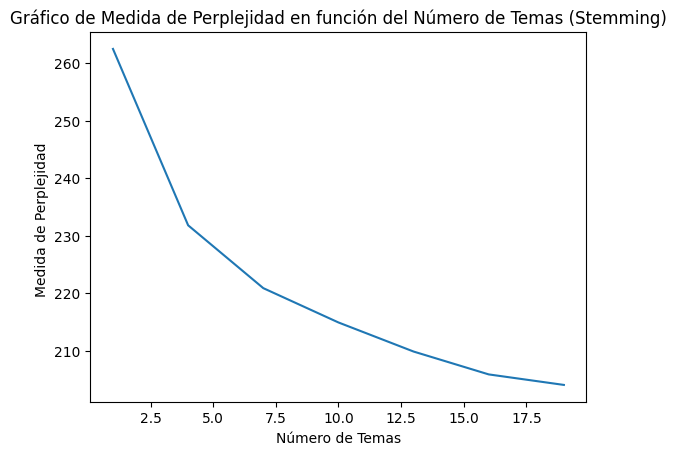

In [ ]:
limit=20; start=1; step=3;
x = range(start, limit, step)
plt.plot(x, valores_p)
plt.xlabel("Número de Temas")
plt.ylabel("Medida de Perplejidad ")
plt.title("Gráfico de Medida de Perplejidad en función del Número de Temas (Stemming)")
plt.show()

Para los 16 temas se observa una Perplejidad baja en el rango evaluado, lo que corrobora la medida anterior de Coherencia.

#### ***c. Modelo Final***

 Por lo anterior, se procede a estimar el modelo con este número de temas:

In [ ]:
Estimacion = LdaModel(
    corpus=corpus_stemming,
    id2word=dictionary_stemming,
    num_topics=16,
    chunksize=1000,
    passes=20,
    iterations=400,
    alpha='auto',
    eta='auto',
    random_state=123,
    eval_every=None
)

Se visualizan los temas:

In [ ]:
pprint(Estimacion.print_topics())

[(0,
  '0.018*"president" + 0.014*"gobiern" + 0.013*"polit" + 0.012*"petr" + '
  '0.011*"pais" + 0.011*"colombi" + 0.007*"ministr" + 0.006*"paz" + '
  '0.006*"congres" + 0.006*"gustav"'),
 (1,
  '0.014*"espan" + 0.013*"chin" + 0.013*"eur" + 0.010*"unid" + 0.009*"europ" + '
  '0.007*"europe" + 0.007*"espanol" + 0.007*"segun" + 0.007*"rusi" + '
  '0.006*"guerr"'),
 (2,
  '0.016*"ciud" + 0.012*"call" + 0.010*"polici" + 0.010*"zon" + 0.009*"bogot" '
  '+ 0.008*"medellin" + 0.008*"segur" + 0.008*"person" + 0.007*"vehicul" + '
  '0.007*"hor"'),
 (3,
  '0.021*"banc" + 0.013*"merc" + 0.013*"millon" + 0.012*"dolar" + '
  '0.010*"inversion" + 0.010*"argentin" + 0.009*"economi" + 0.009*"fond" + '
  '0.009*"us" + 0.008*"credit"'),
 (4,
  '0.016*"agu" + 0.015*"energi" + 0.012*"electr" + 0.009*"gas" + '
  '0.008*"energet" + 0.008*"ambiental" + 0.007*"climat" + 0.006*"carbon" + '
  '0.006*"oper" + 0.006*"proyect"'),
 (5,
  '0.030*"salud" + 0.013*"investig" + 0.012*"nin" + 0.012*"medic" + '
  '0.012*"

Se crea un DataFrame con las 50 palabras más frecuentes en cada tema:

In [ ]:
# Obtiene las palabras clave de cada tema en el modelo Estimacion
temas_estimacion = Estimacion.print_topics(num_topics=16, num_words=50)

# Crea una lista para almacenar los datos de cada tema
data = []

# Recorre los temas y extrae las palabras clave
for tema, palabras in temas_estimacion:
    palabras = palabras.split("+")
    palabras = [palabra.split("*")[1] for palabra in palabras]
    data.append([tema, ", ".join(palabras)])

# Crea un DataFrame con los datos recopilados
df = pd.DataFrame(data, columns=["Tema",  "Palabras Clave"])

# Muestra el DataFrame
df

Tema                                     Palabras Clave
0      0  "president" , "gobiern" , "polit" , "petr" , "...
1      1  "espan" , "chin" , "eur" , "unid" , "europ" , ...
2      2  "ciud" , "call" , "polici" , "zon" , "bogot" ,...
3      3  "banc" , "merc" , "millon" , "dolar" , "invers...
4      4  "agu" , "energi" , "electr" , "gas" , "energet...
5      5  "salud" , "investig" , "nin" , "medic" , "pers...
6      6  "si" , "anos" , "pas" , "trabaj" , "pued" , "s...
7      7  "equip" , "deport" , "colombi" , "jueg" , "fut...
8      8  "present" , "artist" , "anos" , "music" , "cul...
9      9  "inform" , "digital" , "usuari" , "servici" , ...
10    10  "public" , "ley" , "general" , "derech" , "adm...
11    11  "millon" , "ano" , "preci" , "aument" , "pais"...
12    12  "empres" , "pais" , "merc" , "negoci" , "compa...
13    13  "proyect" , "millon" , "contrat" , "bogot" , "...
14    14  "desarroll" , "trabaj" , "educ" , "social" , "...
15    15  "pued" , "product" , "mejor" , "si" , "sol" , ...

Se crea una nube de palabras en cada tema con las 50 palabras más frecuentes:

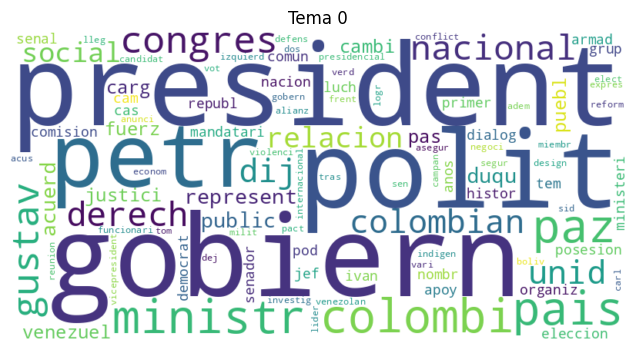

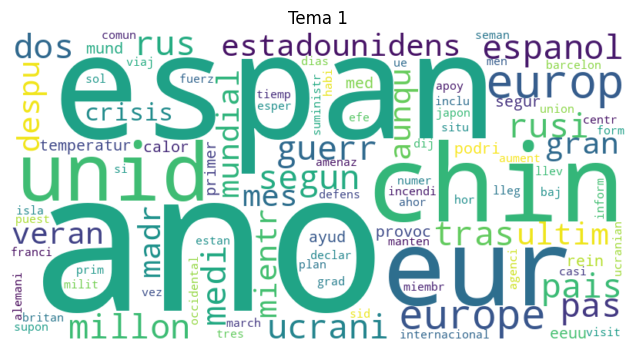

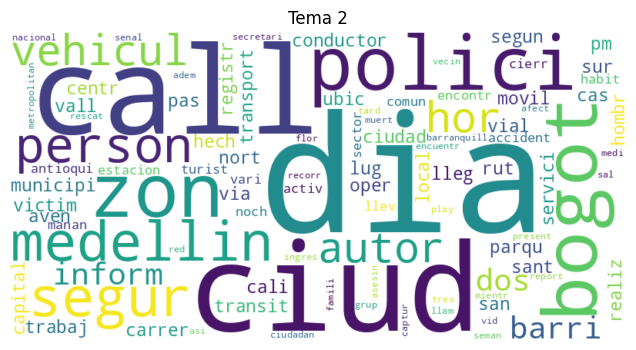

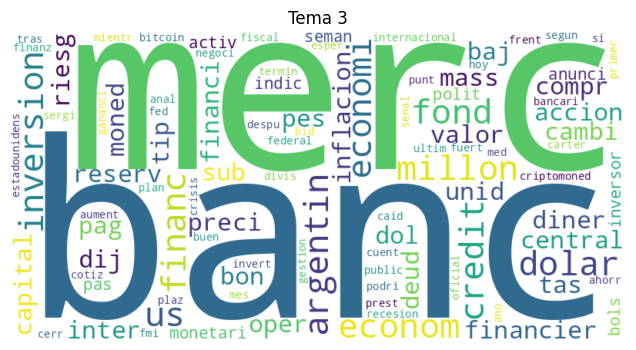

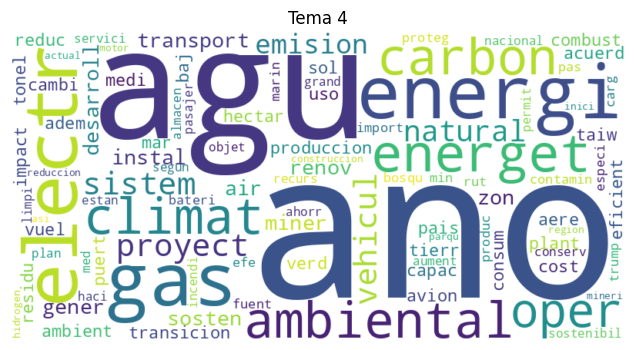

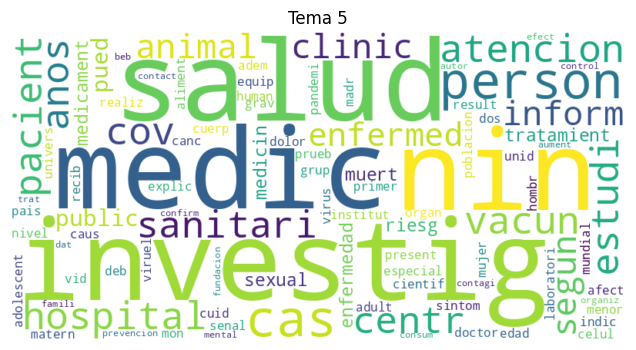

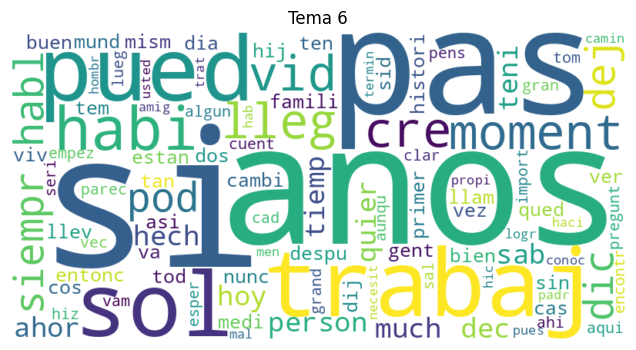

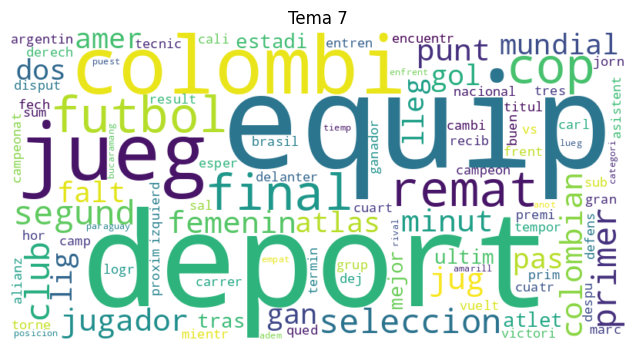

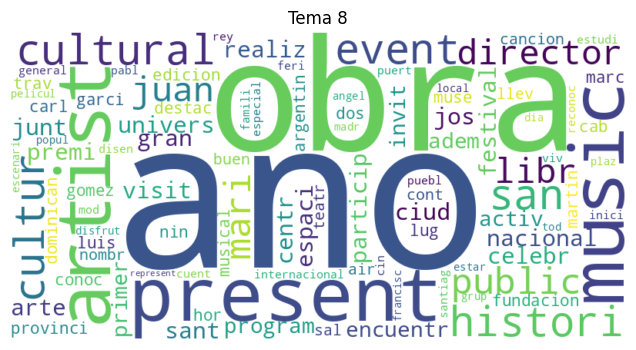

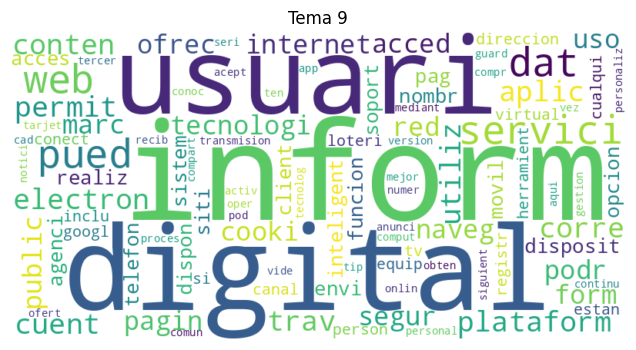

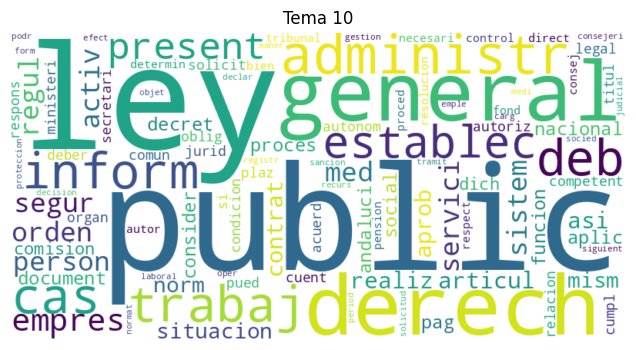

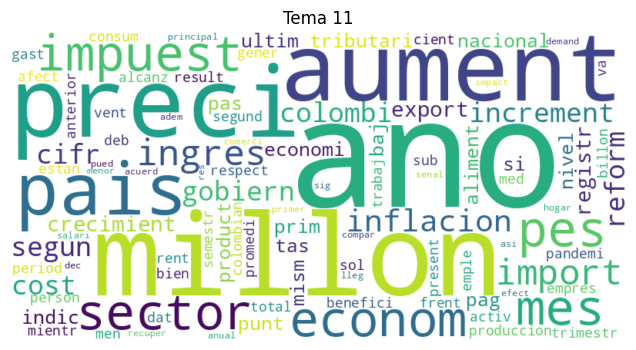

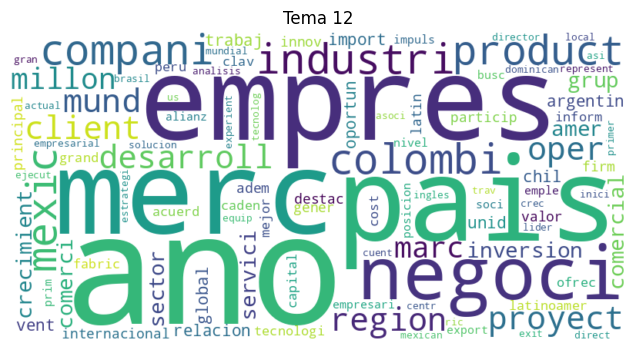

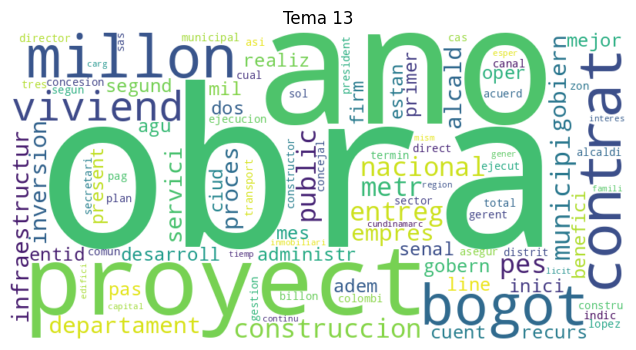

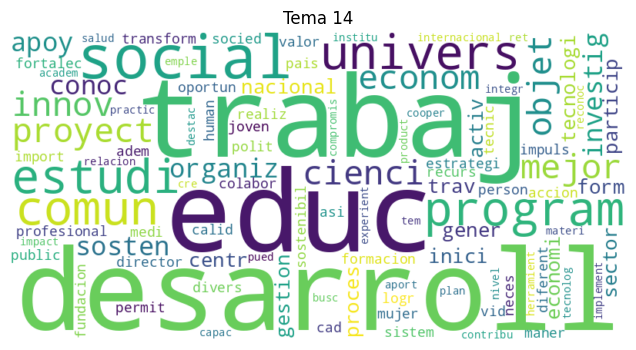

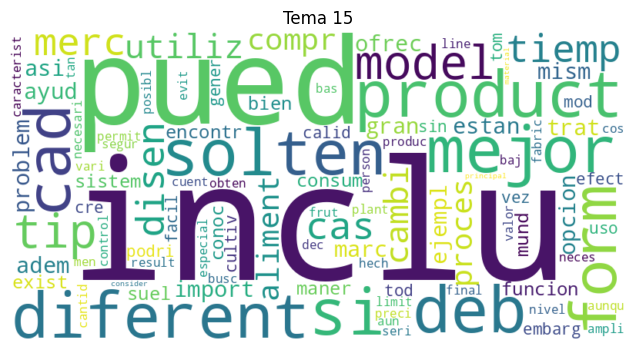

In [ ]:
# Obteniendo los temas generados por el modelo LDA
temas = Estimacion.print_topics(num_topics=16)

# Definiendo una función para crear y mostrar la nube de palabras
def crear_nube_palabras(tema, index):
  words = [word for word, _ in Estimacion.show_topic(tema, topn=100)]
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))

  plt.figure(figsize=(8, 4))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f"Tema {index[0]}")
  plt.show()
  print("")

# Genera y muestra las nubes de palabras para cada tema
for i, tema in enumerate(temas):
  crear_nube_palabras(i, tema)

Se obtienen las probabilidades condicionales de cada noticia respecto a cada tema:

In [ ]:
l=[Estimacion.get_document_topics(item) for item in corpus_stemming]

Ahora, se obtiene la probabilidad más alta de pertenencia de noticia por tema:

In [ ]:
# Se definen las funciones para obtener las probabilidades condicionales máximas de correspondencia por tema
def get_max(doc):
  idx,l = zip(*doc)
  return idx[np.argmax(l)]

def get_max_prob(doc):
  idx,l = zip(*doc)
  return l[np.argmax(l)]

In [ ]:
# Se copia el DF original y se crean las columnas tema y probabilidad
df_bd_stemming_f = df_bd_stemming.copy()
df_bd_stemming_f['Tema'] = [get_max(doc) for doc in Estimacion.get_document_topics(corpus_stemming)]
df_bd_stemming_f['Prob'] = [get_max_prob(doc) for doc in Estimacion.get_document_topics(corpus_stemming)]
df_bd_stemming_f.head(2)

nit    news_id                                  news_url_absolute   
0  800000946  news15986  https://www.infobae.com/cultura/agenda-cultura...  \
1  800000946  news89860  https://acento.com.do/economia/wall-street-cie...   

                                              subsec   
0  manufactura de productos de tocador articulos ...  \
1  manufactura de productos de tocador articulos ...   

                         nombre   
0  procter gamble colombia ltda  \
1  procter gamble colombia ltda   

                                   new_title_content  Tema      Prob  
0  gui arte cultur seman arte agustin galindez qu...     8  0.687677  
1  wall street cierr verd wall street cerr verd d...     3  0.643145

Con ayuda de la funcionalidad de pyLDAvis, se crea la visualización de los temas proyectado en un plano bidimensional PC1 y PC2.

In [ ]:
# Visualizamos los resultados
pyLDAvis.enable_notebook()
LDA_visualization = gensimvis.prepare(Estimacion, corpus = corpus_stemming, dictionary = dictionary_stemming)
LDA_visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.120371  0.007778       1        1  10.609714
14     0.120121 -0.026692       2        1  10.136191
6     -0.052728  0.014496       3        1   9.714630
15     0.120477  0.050621       4        1   8.050220
10     0.135316 -0.033088       5        1   7.642416
12     0.020164  0.066843       6        1   7.511517
8     -0.153656 -0.210907       7        1   7.148219
11     0.033081  0.189829       8        1   7.105493
13    -0.033620 -0.009334       9        1   4.854664
4      0.051750  0.059577      10        1   4.703891
1     -0.077390  0.121550      11        1   4.631921
3     -0.004417  0.190938      12        1   4.401248
2     -0.114386 -0.153270      13        1   3.822840
7     -0.226336 -0.019661      14        1   3.431834
5      0.050416 -0.053114      15        1   3.428898
9      0.251578 -0.195566      16        1   2.806304, topic_info=           Term          Freq         Total Category  logprob  loglift
1269     empres  23735.000000  23735.000000  Default  30.0000  30.0000
3202      salud  11316.000000  11316.000000  Default  29.0000  29.0000
2341     millon  24088.000000  24088.000000  Default  28.0000  28.0000
3825       merc  15227.000000  15227.000000  Default  27.0000  27.0000
1050  desarroll  23574.000000  23574.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
2552      ofrec   1302.329692   5940.737541  Topic16  -5.0836   2.0556
3238      segur   1399.507733  12264.093646  Topic16  -5.0116   1.4027
3638        uso   1208.421661   5684.777345  Topic16  -5.1584   2.0248
2926     public   1404.574301  23400.727622  Topic16  -5.0080   0.7603
1574       form   1139.394198  13318.109875  Topic16  -5.2173   1.1147

[1307 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
24         2  0.888436      academ
24         5  0.000853      academ
24         7  0.098573      academ
24        15  0.011521      academ
27         2  0.174389       acced
...      ...       ...         ...
3797      11  0.073630         zon
3797      13  0.372625         zon
3797      14  0.038917         zon
11148     16  0.989505  zuckerberg
9984       2  0.990319       zulet

[4630 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 15, 7, 16, 11, 13, 9, 12, 14, 5, 2, 4, 3, 8, 6, 10])

Se identifica la buena separación de varios de los temas. Sin embargo, al ser un plano bidimensional esos temas que se visualizan de manera traslapada en el plano no necesariamente se están interfiriendo como el tema 2 y el tema 5.

Finalmente, se crea un nuevo DataFrame para exportar como csv y manualmente realizar una asignación de nombre por tema, teniendo en cuenta los requerimientos mínimos del negocio.

In [ ]:
df_noticias=pd.read_csv('../Data/noticias.csv')

In [ ]:
df_bd_stemming_f2 = pd.merge(df_bd_stemming_f, df[['Tema','Palabras Clave']], on='Tema')
df_bd_stemming_f2 = pd.merge(df_bd_stemming_f2, df_noticias[['news_id','news_title','news_text_content']], on='news_id')
df_bd_stemming_f2.head(2)

nit    news_id                                  news_url_absolute   
0  800000946  news15986  https://www.infobae.com/cultura/agenda-cultura...  \
1  800011161  news17955  https://www.infobae.com/america/colombia/2022/...   

                                              subsec   
0  manufactura de productos de tocador articulos ...  \
1                                        automotores   

                         nombre   
0  procter gamble colombia ltda  \
1                 alciautos sas   

                                   new_title_content  Tema      Prob   
0  gui arte cultur seman arte agustin galindez qu...     8  0.687677  \
1  sol habr desfil conciert celebr dia independen...     8  0.382561   

                                      Palabras Clave   
0  "present" , "artist" , "anos" , "music" , "cul...  \
1  "present" , "artist" , "anos" , "music" , "cul...   

                                          news_title   
0  Guia de Arte y Cultura: semana del 12 al 19 de...  \
1  No solo habra desfiles el 20 de julio, estos s...   

                                   news_text_content  
0  ARTE Agustina Galindez Quesada exhibe "Catarsi...  
1  El Dia de la Independencia, este miercoles 20 ...

Se guarda el DataFrame en un csv:

In [ ]:
ruta_csv = '../Data/DC_stemming_temas.csv'
df_bd_stemming_f2.to_csv(ruta_csv, index=False)

Realizando la inspección de las nubes de palabra, los archivos de salida y los cluster formados se llega a la siguiente asignación:

*   Tema 0: Política
*   Tema 1: Innovación
*   Tema 2: Cultura
*   Tema 3: Macroeconomía
*   Tema 4: Alianzas
*   Tema 5: Otra
*   Tema 6: Reputación
*   Tema 7: Sostenibilidad
*   Tema 8: Regulaciones
*   Tema 9: Salud
*   Tema 10: Alianzas
*   Tema 11: Macroeconomía
*   Tema 12: Macroeconomía
*   Tema 13: Regulaciones
*   Tema 14: Deporte
*   Tema 15: Otra

El negocio necesitaba identificar mínimamente las categorías de:

* Macroeconomia
* Sostenibilidad
* Innovacion
* Regulaciones
* Alianzas
* Reputacion
* Otra

Sin embargo, el algoritmo logró identificar otras noticias que tenían un contenido diferente al propuesto por el negocio por ello se procede a tener en cuenta sus etiquetas para el recomendador.


Evidentemente se pueden agrupar algunos temas. Los temas 3, 11 y 12 en `Macroeconomía`, 8 y 13 `Regulaciones`, 4 y 10 `Alianzas`, 5 y 15 en `Otra`.

Los temas quedarían de la siguiente manera:

*   Macroeconomía : 3, 11 y 12
*   Innovación : 1
*   Sostenibilidad : 7
*   Alianzas : 4 y 10
*   Reputación : 6
*   Regulaciones : 8 y 13
*   Política: 0
*   Cultura: 2
*   Salud: 9
*   Deportes: 14
*   Otra : 5 y 15

In [ ]:
condicion = lambda x: 'Macroeconómicas' if x in [3, 11, 12] else ('Innovación' if x in [1]
                                                                     else ('Sostenibilidad' if x in [7]
                                                                           else ('Alianzas' if x in [4,10]
                                                                                 else ('Reputación' if x in [6]
                                                                                       else ('Regulaciones' if x in [8,13]
                                                                                             else ('Política' if x in [0]
                                                                                                   else ('Cultura' if x in [2]
                                                                                                         else ('Salud' if x in [9]
                                                                                                               else ('Deportes' if x in [14]
                                                                                                                     else ('Otra' if x in [5,15] else x))))))))))

# Aplicar la función lambda a la columna "Tema" y crear la nueva columna
df_bd_stemming_f2['Tema_texto'] = df_bd_stemming_f2['Tema'].apply(condicion)

df_bd_stemming_f2.head(3)

nit    news_id                                  news_url_absolute   
0  800000946  news15986  https://www.infobae.com/cultura/agenda-cultura...  \
1  800011161  news17955  https://www.infobae.com/america/colombia/2022/...   
2  800015615  news96447  https://misionesonline.net/2022/08/02/black-fr...   

                                              subsec   
0  manufactura de productos de tocador articulos ...  \
1                                        automotores   
2                                         ferreteria   

                         nombre   
0  procter gamble colombia ltda  \
1                 alciautos sas   
2                    marpico sa   

                                   new_title_content  Tema      Prob   
0  gui arte cultur seman arte agustin galindez qu...     8  0.687677  \
1  sol habr desfil conciert celebr dia independen...     8  0.382561   
2  black friday comerci posaden promet fiest real...     8  0.199174   

                                      Palabras Clave   
0  "present" , "artist" , "anos" , "music" , "cul...  \
1  "present" , "artist" , "anos" , "music" , "cul...   
2  "present" , "artist" , "anos" , "music" , "cul...   

                                          news_title   
0  Guia de Arte y Cultura: semana del 12 al 19 de...  \
1  No solo habra desfiles el 20 de julio, estos s...   
2  Black Friday | Comerciantes posadenos prometen...   

                                   news_text_content    Tema_texto  
0  ARTE Agustina Galindez Quesada exhibe "Catarsi...  Regulaciones  
1  El Dia de la Independencia, este miercoles 20 ...  Regulaciones  
2  Desde este jueves se realizara en Posadas la y...  Regulaciones

Se identifica la cantidad de noticias por agrupación:

In [ ]:
df_bd_stemming_f2['Tema_texto'].value_counts()

Tema_texto
Macroeconómicas    5336
Política           2798
Regulaciones       2755
Deportes           2528
Alianzas           2320
Otra               1926
Reputación         1526
Sostenibilidad     1179
Cultura            1138
Salud               846
Innovación          648
Name: count, dtype: int64

La mayoría de las noticias son de macroeconomía.

Ahora, se procede a guardar el set de datos con los respectivos temas asignados con el texto tratado con stemming:

In [ ]:
ruta_csv = '../Data/DC_stemming_tema_asignado.csv'
df_bd_stemming_f2.to_csv(ruta_csv, index=False)

### ***3.2 Modelo de clustering: LDA - Lematización***

In [ ]:
df_bd_lemat=pd.read_csv('../Data/DC_lematizacion.csv')

Con el texto limpio por Lematizacción se procede a agruparlo por temas:

In [ ]:
tokens_lematizados = [word_tokenize(texto) for texto in df_bd_lemat['new_title_content']]

# Creamos la representación de diccionario del documento
dictionary_lematizados = Dictionary(tokens_lematizados)

# Se remueven las palabras que aparecen en menos de 20 documentos y más del 50% de los documentos
dictionary_lematizados.filter_extremes(no_below=20, no_above=0.5)

# Se vectoriza el documento para crear el corpus con la matriz de frecuencia
corpus_lematizados = [dictionary_lematizados.doc2bow(doc) for doc in tokens_lematizados]

print('Numero de palabras únicas: %d' % len(dictionary_lematizados))

Numero de palabras únicas: 23374


Antes de definir el modelo se va a realizar la validacion de coherencia y perplejidad para definir el mejor número de topicos

#### ***Coherencia***

In [ ]:
modelos, valores_c = calcular_coherencia(dictionary=dictionary_lematizados, corpus=corpus_lematizados, texts=tokens_lematizados, start=1, limit=20, step=3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


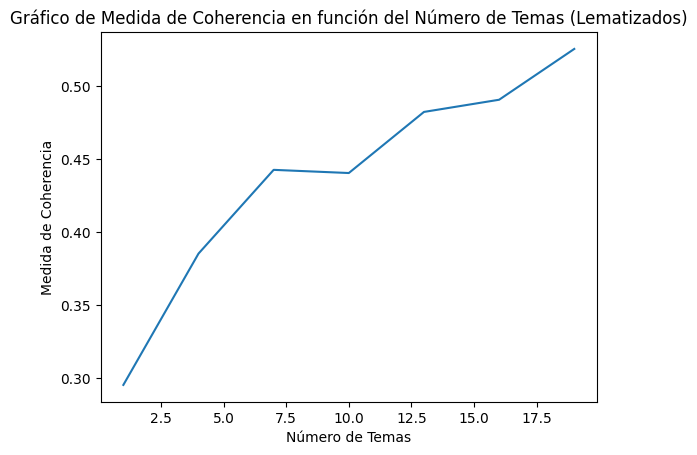

In [ ]:
limit=20; start=1; step=3;
x = range(start, limit, step)
plt.plot(x, valores_c)
plt.xlabel("Número de Temas")
plt.ylabel("Medida de Coherencia")
plt.title("Gráfico de Medida de Coherencia en función del Número de Temas (Lematizados)")
plt.show()

La mayor coherencia se observa en los primeros 16 temas.

#### ***Perplejidad***

In [ ]:
modelos, valores_p = perplejidad_ntemas(dictionary=dictionary_lematizados, corpus=corpus_lematizados, texts=tokens_lematizados, start=1, limit=20, step=3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


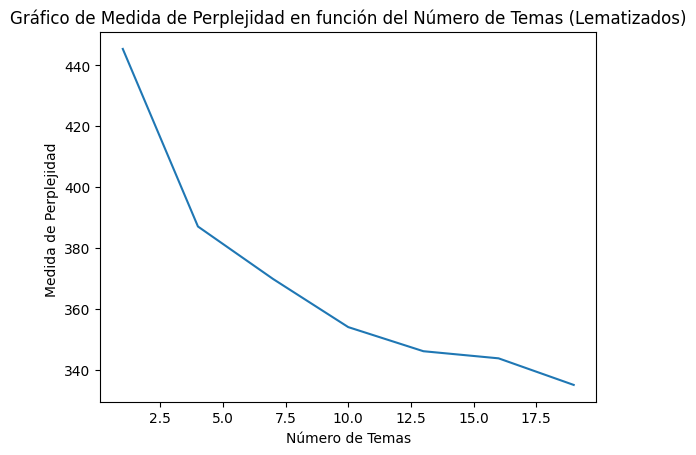

In [ ]:
limit=20; start=1; step=3;
x = range(start, limit, step)
plt.plot(x, valores_p)
plt.xlabel("Número de Temas")
plt.ylabel("Medida de Perplejidad ")
plt.title("Gráfico de Medida de Perplejidad en función del Número de Temas (Lematizados)")
plt.show()

Para los 19 temas se observa una coherencia baja en el rango evaluado, lo que corrobora la medida anterior de Coherencia. Por lo anterior, se procede a estimar el modelo con este número de temas:

#### ***Modelo Final***

 Por lo anterior, se procede a estimar el modelo con este número de temas (19):

In [ ]:
Estimacion_lemat = LdaModel(
    corpus=corpus_lematizados,
    id2word=dictionary_lematizados,
    num_topics=19,
    chunksize=1000,
    passes=20,
    iterations=400,
    alpha='auto',
    eta='auto',
    random_state=123,
    eval_every=None
)

Se visualizan los temas:

In [ ]:
pprint(Estimacion_lemat.print_topics())

[(0,
  '0.011*"ciudad" + 0.009*"zona" + 0.007*"metro" + 0.006*"bogota" + '
  '0.005*"transporte" + 0.005*"centro" + 0.005*"obras" + 0.005*"construccion" '
  '+ 0.005*"proyecto" + 0.004*"calle"'),
 (1,
  '0.010*"solo" + 0.010*"ano" + 0.009*"puede" + 0.009*"hace" + 0.009*"hacer" + '
  '0.008*"ahora" + 0.007*"bien" + 0.007*"tener" + 0.006*"estan" + '
  '0.006*"hecho"'),
 (2,
  '0.016*"desarrollo" + 0.012*"pais" + 0.009*"colombia" + 0.009*"empresas" + '
  '0.008*"proyectos" + 0.008*"innovacion" + 0.007*"sector" + 0.007*"programa" '
  '+ 0.007*"trave" + 0.006*"region"'),
 (3,
  '0.014*"millones" + 0.014*"banco" + 0.013*"dolares" + 0.013*"mercado" + '
  '0.012*"inflacion" + 0.009*"economia" + 0.008*"dolar" + 0.007*"inversion" + '
  '0.006*"precios" + 0.006*"capital"'),
 (4,
  '0.007*"social" + 0.007*"trabajo" + 0.006*"desarrollo" + 0.006*"gobierno" + '
  '0.004*"medidas" + 0.004*"plan" + 0.004*"politicas" + 0.004*"sistema" + '
  '0.004*"politica" + 0.004*"sociedad"'),
 (5,
  '0.014*"mercado"

Se crea un DataFrame con las 50 palabras más frecuentes en cada tema:

In [ ]:
# Obtiene las palabras clave de cada tema en el modelo Estimacion
temas_estimacion_lemat = Estimacion_lemat.print_topics(num_topics=19, num_words=50)

# Crea una lista para almacenar los datos de cada tema
data_lemat = []

# Recorre los temas y extrae las palabras clave
for tema, palabras in temas_estimacion_lemat:
    palabras = palabras.split("+")
    palabras = [palabra.split("*")[1] for palabra in palabras]
    data_lemat.append([tema, ", ".join(palabras)])

# Crea un DataFrame con los datos recopilados
df2 = pd.DataFrame(data_lemat, columns=["Tema", "Palabras Clave"])

# Muestra el DataFrame
df2

Tema                                     Palabras Clave
0      0  "ciudad" , "zona" , "metro" , "bogota" , "tran...
1      1  "solo" , "ano" , "puede" , "hace" , "hacer" , ...
2      2  "desarrollo" , "pais" , "colombia" , "empresas...
3      3  "millones" , "banco" , "dolares" , "mercado" ,...
4      4  "social" , "trabajo" , "desarrollo" , "gobiern...
5      5  "mercado" , "clientes" , "empresa" , "digital"...
6      6  "millones" , "aumento" , "segun" , "precios" ,...
7      7  "salud" , "andalucia" , "hospital" , "informac...
8      8  "historia" , "ano" , "vida" , "musica" , "cult...
9      9  "presidente" , "gobierno" , "petro" , "colombi...
10    10  "persona" , "salud" , "mujeres" , "ninos" , "c...
11    11  "universidad" , "nacional" , "general" , "dire...
12    12  "argentina" , "ano" , "tras" , "fernandez" , "...
13    13  "millones" , "peso" , "gobierno" , "reforma" ,...
14    14  "unidos" , "china" , "paises" , "dijo" , "rusi...
15    15  "empresas" , "proyectos" , "servicios" , "cont...
16    16  "policia" , "segun" , "caso" , "autoridades" ,...
17    17  "agua" , "energia" , "produccion" , "ambiental...
18    18  "colombia" , "equipo" , "futbol" , "copa" , "p...

Se crea una nube de palabras en cada tema con las 50 palabras más frecuentes:

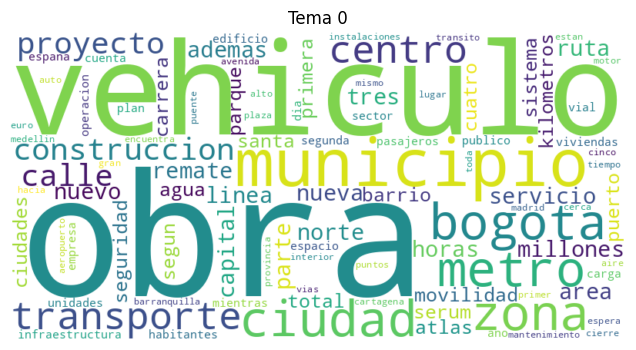

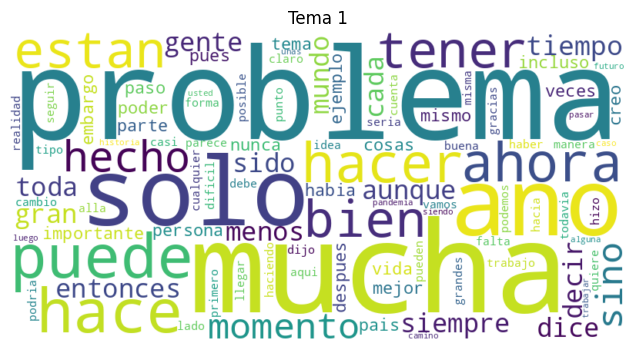

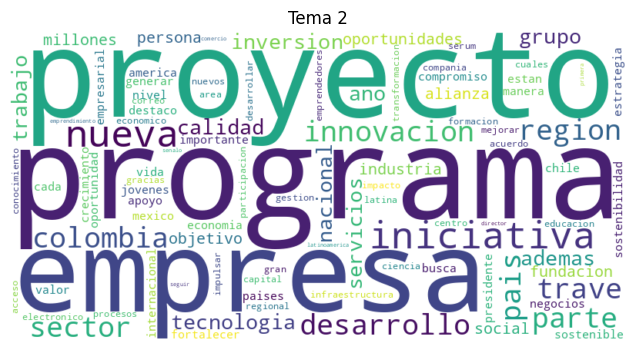

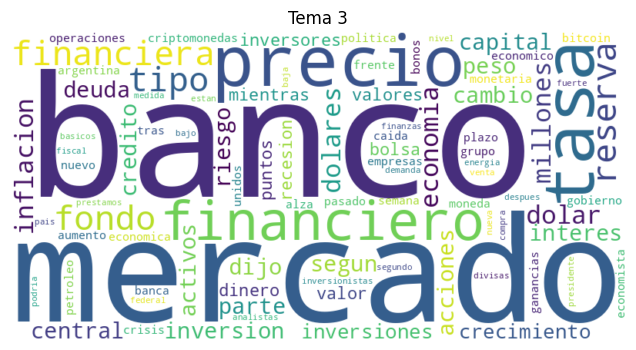

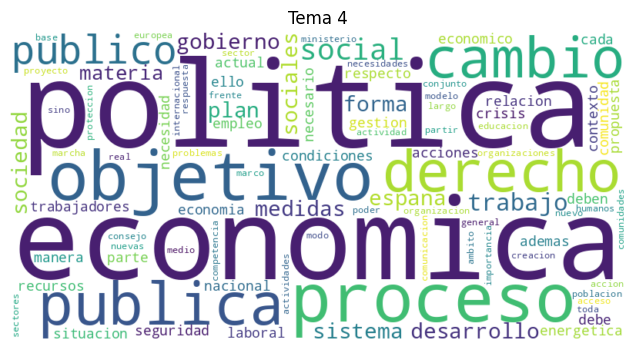

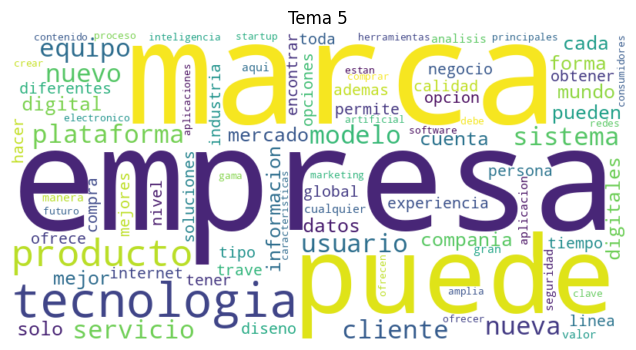

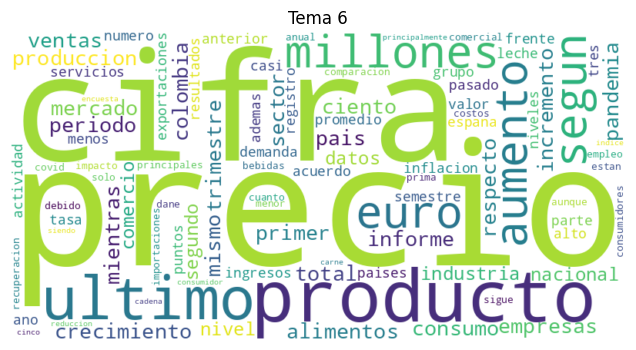

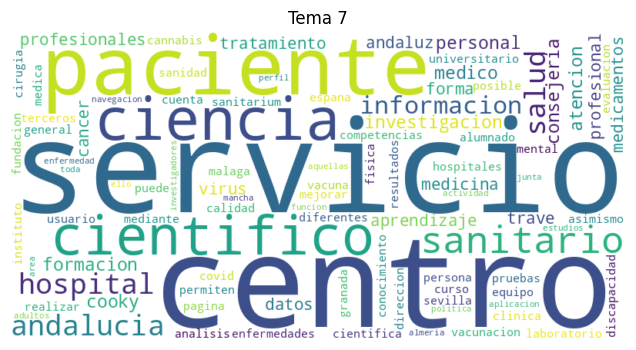

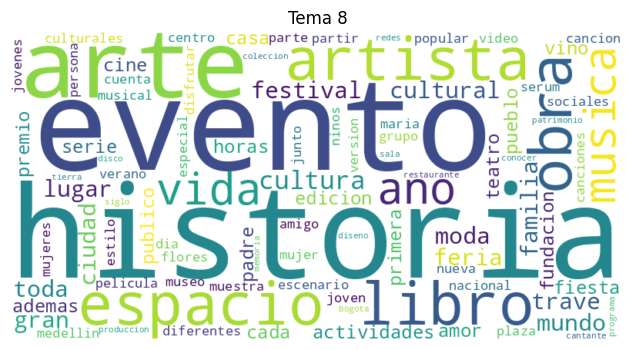

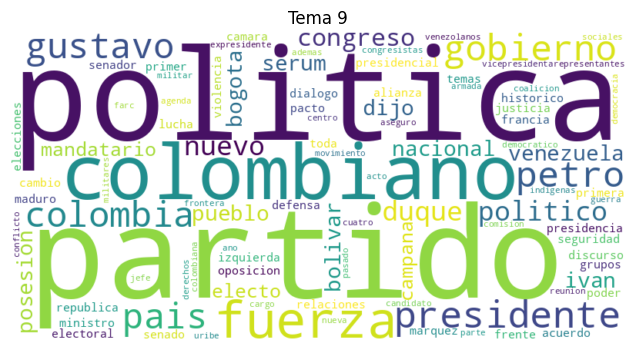

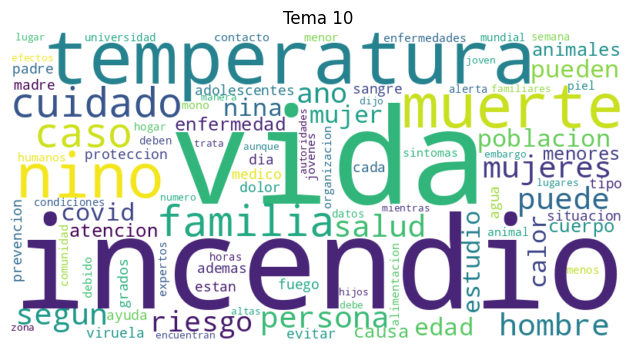

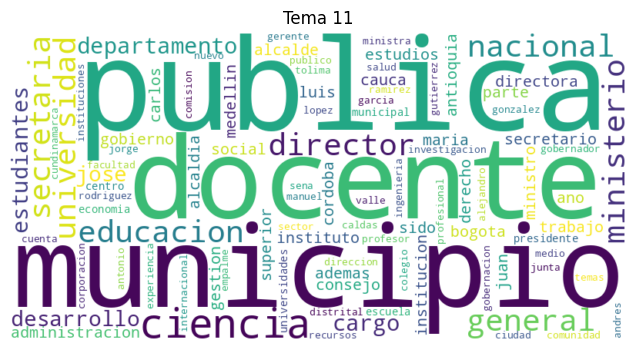

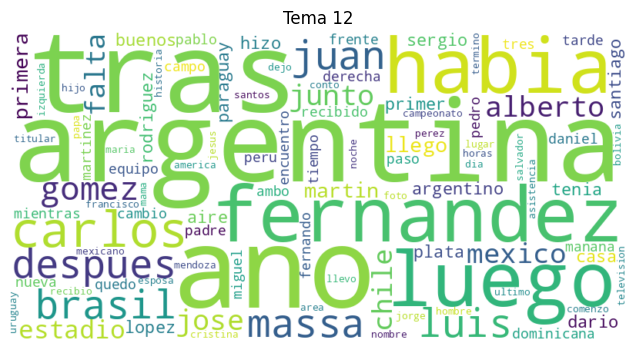

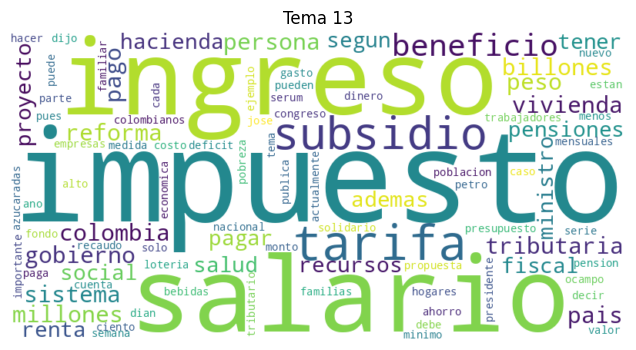

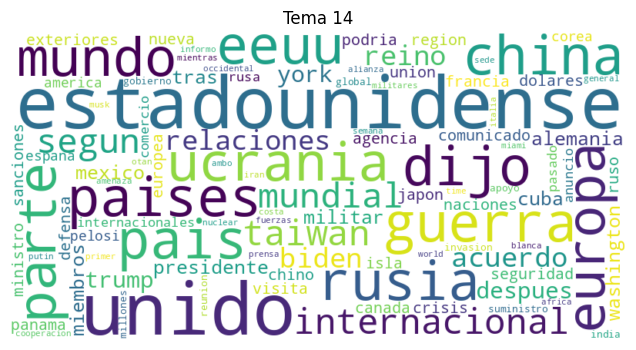

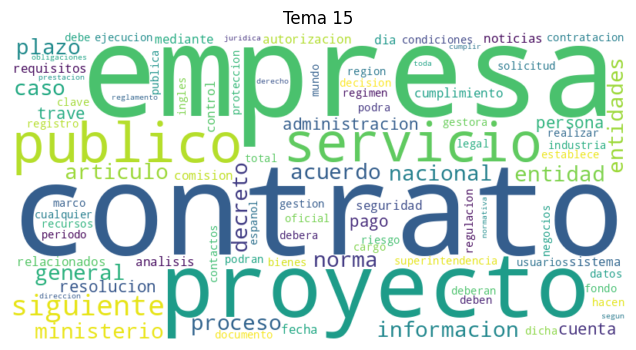

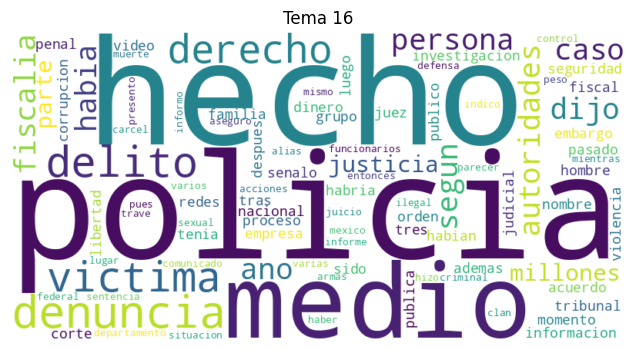

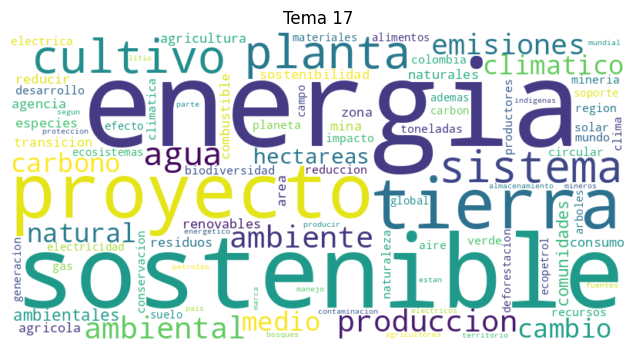

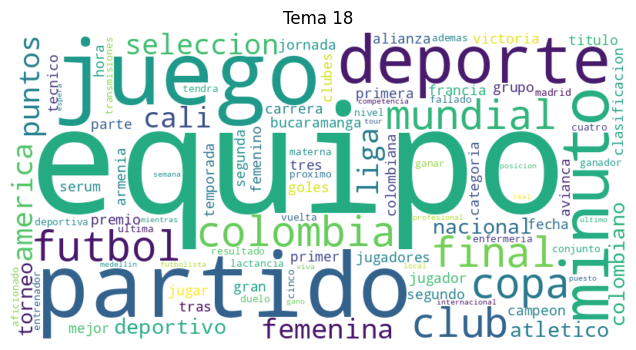

In [ ]:
# Obteniendo los temas generados por el modelo LDA
temas = Estimacion_lemat.print_topics(num_topics=19)

# Definiendo una función para crear y mostrar la nube de palabras
def crear_nube_palabras(tema, index):
  words = [word for word, _ in Estimacion_lemat.show_topic(tema, topn=100)]
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))

  plt.figure(figsize=(8, 4))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f"Tema {index[0]}")
  plt.show()
  print("")

# Genera y muestra las nubes de palabras para cada tema
for i, tema in enumerate(temas):
  crear_nube_palabras(i, tema)

Se obtienen las probabilidades condicionales de cada noticia respecto a cada tema:

In [ ]:
l_lemat=[Estimacion_lemat.get_document_topics(item) for item in corpus_lematizados]

Ahora, se obtiene la probabilidad más alta de pertenencia de noticia por tema:

In [ ]:
# Se definen las funciones para obtener las probabilidades condicionales máximas de correspondencia por tema
def get_max(doc):
  idx,l_lemat = zip(*doc)
  return idx[np.argmax(l_lemat)]

def get_max_prob(doc):
  idx,l_lemat = zip(*doc)
  return l_lemat[np.argmax(l_lemat)]

In [ ]:
# Se copia el DF original y se crean las columnas tema y probabilidad
df_bd_lemat_f = df_bd_lemat.copy()
df_bd_lemat_f['Tema'] = [get_max(doc) for doc in Estimacion_lemat.get_document_topics(corpus_lematizados)]
df_bd_lemat_f['Prob'] = [get_max_prob(doc) for doc in Estimacion_lemat.get_document_topics(corpus_lematizados)]
df_bd_lemat_f.head(2)

nit    news_id                                  news_url_absolute   
0  800000946  news15986  https://www.infobae.com/cultura/agenda-cultura...  \
1  800000946  news89860  https://acento.com.do/economia/wall-street-cie...   

                                              subsec   
0  manufactura de productos de tocador articulos ...  \
1  manufactura de productos de tocador articulos ...   

                         nombre   
0  procter gamble colombia ltda  \
1  procter gamble colombia ltda   

                                   new_title_content  Tema      Prob  
0  guia arte cultura semana arte agustina galinde...     8  0.769039  
1  wall street cierra verde wall street cerro ver...     3  0.767428

Con ayuda de la funcionalidad de pyLDAvis, se crea la visualización de los temas proyectado en un plano bidimensional PC1 y PC2.

In [ ]:
# Visualizamos los resultados
pyLDAvis.enable_notebook()
LDA_visualization_lemat = gensimvis.prepare(Estimacion_lemat, corpus = corpus_lematizados, dictionary = dictionary_lematizados)
LDA_visualization_lemat

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.007418 -0.093584       1        1  12.079013
4     -0.109996  0.040838       2        1   9.341655
0      0.021335  0.038173       3        1   8.030447
2     -0.077031  0.047150       4        1   7.759485
8      0.078377  0.176814       5        1   6.204567
5     -0.186547  0.030124       6        1   6.201945
6     -0.092232 -0.194547       7        1   5.961793
9      0.217668 -0.011661       8        1   5.521555
11     0.120126  0.171408       9        1   5.119038
15    -0.150878  0.040105      10        1   4.690303
16     0.104101 -0.031874      11        1   4.511956
3     -0.021148 -0.235430      12        1   4.443462
12     0.287521  0.027982      13        1   4.386493
14     0.092443 -0.113292      14        1   3.339168
17    -0.151591 -0.045101      15        1   2.963529
13    -0.046144 -0.136030      16        1   2.902517
7     -0.180996  0.259865      17        1   2.608178
10    -0.039199 -0.004967      18        1   2.341642
18     0.126774  0.034025      19        1   1.593252, topic_info=          Term          Freq         Total Category  logprob  loglift
884   colombia  21655.000000  21655.000000  Default  30.0000  30.0000
3191  millones  23765.000000  23765.000000  Default  29.0000  29.0000
3717   persona  19213.000000  19213.000000  Default  28.0000  28.0000
2282  gobierno  19186.000000  19186.000000  Default  27.0000  27.0000
4430     salud  10395.000000  10395.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
3201   minutos    633.460700   1729.094897  Topic19  -5.1680   3.1352
3320  nacional    843.720834  17507.347609  Topic19  -4.8814   1.1068
2445      hora    598.691554   2798.651277  Topic19  -5.2245   2.5972
4519     serum    640.868225   8215.734766  Topic19  -5.1564   1.5884
3943   primera    641.940293   9389.141073  Topic19  -5.1547   1.4566

[1464 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
6169      6  0.991021   abejas
21        1  0.012034  abordar
21        2  0.792915  abordar
21        5  0.017383  abordar
21        6  0.062845  abordar
...     ...       ...      ...
5157     11  0.008169     zona
5157     14  0.020769     zona
5157     15  0.155764     zona
5157     16  0.032261     zona
5157     18  0.046383     zona

[4744 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 3, 9, 6, 7, 10, 12, 16, 17, 4, 13, 15, 18, 14, 8, 11, 19])

Se identifica la buena separación de varios de los temas. Sin embargo, al ser un plano bidimensional esos temas que se visualizan de manera traslapada en el plano no necesariamente se están interfiriendo como el tema 6, 10, 2 y 4. En comparación con el modelo de stemming se ve un poco mejor la agrupación.

Finalmente, se crea un nuevo DataFrame para exportar como csv y manualmente realizar una asignación de nombre por tema, teniendo en cuenta los requerimientos mínimos del negocio.

In [ ]:
df_bd_lemat_f2 = pd.merge(df_bd_lemat_f, df2[['Tema','Palabras Clave']], on='Tema')
df_bd_lemat_f2 = pd.merge(df_bd_lemat_f2, df_noticias[['news_id','news_title','news_text_content']], on='news_id')
df_bd_lemat_f2.head(2)

nit    news_id                                  news_url_absolute   
0  800000946  news15986  https://www.infobae.com/cultura/agenda-cultura...  \
1  800000946  news94698  https://www.infobae.com/america/colombia/2022/...   

                                              subsec   
0  manufactura de productos de tocador articulos ...  \
1  manufactura de productos de tocador articulos ...   

                         nombre   
0  procter gamble colombia ltda  \
1  procter gamble colombia ltda   

                                   new_title_content  Tema      Prob   
0  guia arte cultura semana arte agustina galinde...     8  0.769039  \
1  bebidas organicas veganas novedades expovinos ...     8  0.271894   

                                      Palabras Clave   
0  "historia" , "ano" , "vida" , "musica" , "cult...  \
1  "historia" , "ano" , "vida" , "musica" , "cult...   

                                          news_title   
0  Guia de Arte y Cultura: semana del 12 al 19 de...  \
1  Bebidas organicas y veganas: novedades de Expo...   

                                   news_text_content  
0  ARTE Agustina Galindez Quesada exhibe "Catarsi...  
1  Tras dos anos de realizarse en formato virtual...

Se guarda el DataFrame en un csv:

In [ ]:
ruta_csv = '../Data/DC_lematizacion_temas.csv'
df_bd_lemat_f2.to_csv(ruta_csv, index=False)

Realizando la inspección de las nubes de palabra, los archivos de salida y los cluster formados se llega a la siguiente asignación:

*   Tema 0: Otra
*   Tema 1: Regulaciones
*   Tema 2: Alianzas
*   Tema 3: Macroeconomía
*   Tema 4: Política
*   Tema 5: Innovación
*   Tema 6: Macroeconomía
*   Tema 7: Salud
*   Tema 8: Cultura
*   Tema 9: Política
*   Tema 10: Otra
*   Tema 11: Otra
*   Tema 12: Otra
*   Tema 13: Macroeconomía
*   Tema 14: Alianzas
*   Tema 15: Regulaciones
*   Tema 16: Reputación
*   Tema 17: Sostenibilidad
*   Tema 18: Deportes

El negocio necesitaba identificar mínimamente las categorías de:

* Macroeconomia
* Sostenibilidad
* Innovacion
* Regulaciones
* Alianzas
* Reputacion
* Otra

Sin embargo, el algoritmo logró identificar otras noticias que tenían un contenido diferente al propuesto por el negocio por ello se procede a tener en cuenta sus etiquetas para el recomendador.


Evidentemente se pueden agrupar algunos temas. Los temas 3, 11 y 12 en `Macroeconomía`, 8 y 13 `Regulaciones`, 4 y 10 `Alianzas`, 5 y 15 en `Otra`.

Los temas quedarían de la siguiente manera:

*   Macroeconomía : 3, 6 y 13
*   Innovación : 5
*   Sostenibilidad : 17
*   Alianzas : 2 y 14
*   Reputación : 16
*   Regulaciones : 1 y 15
*   Política: 4 y 9
*   Cultura: 8
*   Salud: 7
*   Deportes: 18
*   Otra : 0, 10, 11 y 12

In [ ]:
condicion = lambda x: 'Macroeconómicas' if x in [3, 6,13] else ('Innovación' if x in [5]
                                                                     else ('Sostenibilidad' if x in [17]
                                                                           else ('Alianzas' if x in [2,14]
                                                                                 else ('Reputación' if x in [16]
                                                                                       else ('Regulaciones' if x in [1,15]
                                                                                             else ('Política' if x in [4,9]
                                                                                                   else ('Cultura' if x in [8]
                                                                                                         else ('Salud' if x in [7]
                                                                                                               else ('Deportes' if x in [18]
                                                                                                                     else ('Otra' if x in [0,10,11,12] else x))))))))))

# Aplicar la función lambda a la columna "Tema" y crear la nueva columna
df_bd_lemat_f2['Tema_texto'] = df_bd_lemat_f2['Tema'].apply(condicion)

df_bd_lemat_f2.head(3)

nit    news_id                                  news_url_absolute   
0  800000946  news15986  https://www.infobae.com/cultura/agenda-cultura...  \
1  800000946  news94698  https://www.infobae.com/america/colombia/2022/...   
2  800011161  news17955  https://www.infobae.com/america/colombia/2022/...   

                                              subsec   
0  manufactura de productos de tocador articulos ...  \
1  manufactura de productos de tocador articulos ...   
2                                        automotores   

                         nombre   
0  procter gamble colombia ltda  \
1  procter gamble colombia ltda   
2                 alciautos sas   

                                   new_title_content  Tema      Prob   
0  guia arte cultura semana arte agustina galinde...     8  0.769039  \
1  bebidas organicas veganas novedades expovinos ...     8  0.271894   
2  solo habra desfiles conciertos celebrara indep...     8  0.364614   

                                      Palabras Clave   
0  "historia" , "ano" , "vida" , "musica" , "cult...  \
1  "historia" , "ano" , "vida" , "musica" , "cult...   
2  "historia" , "ano" , "vida" , "musica" , "cult...   

                                          news_title   
0  Guia de Arte y Cultura: semana del 12 al 19 de...  \
1  Bebidas organicas y veganas: novedades de Expo...   
2  No solo habra desfiles el 20 de julio, estos s...   

                                   news_text_content Tema_texto  
0  ARTE Agustina Galindez Quesada exhibe "Catarsi...    Cultura  
1  Tras dos anos de realizarse en formato virtual...    Cultura  
2  El Dia de la Independencia, este miercoles 20 ...    Cultura

Se identifica la cantidad de noticias por agrupación:

In [ ]:
df_bd_lemat_f2['Tema_texto'].value_counts()

Tema_texto
Otra               4553
Macroeconómicas    3359
Alianzas           3349
Regulaciones       3232
Política           2707
Cultura            1481
Innovación         1465
Reputación         1317
Deportes            650
Sostenibilidad      537
Salud               350
Name: count, dtype: int64

Bajo este modelamiento, la categoría que tiene más noticias clasificas es `Otra`, pero le sigue las `Macroeconómicas`. En el modelo por stemming la categoría que menos noticias asociadas tenía era la categoría de `Otra`, pero si coincide con un número muy alto en la de `Macroeconómicas`.

Ahora, se procede a guardar el set de datos con los respectivos temas asignados con el texto tratado con lematización:

In [ ]:
ruta_csv = '../Data/DC_lematizado_tema_asignado.csv'
df_bd_lemat_f2.to_csv(ruta_csv, index=False)